In [89]:
# ======================================================
# STEP 1: SYNTHETIC DATA GENERATION
# ======================================================

import numpy as np
import pandas as pd

def SyntheticDiabetesDataGenerator(n_samples=500, seed=None):
    if seed is not None:
        np.random.seed(seed)

    df = pd.DataFrame()

    # Demographics
    df["Gender"] = np.random.choice([0, 1], size=n_samples)  # 0=female, 1=male
    df["Race"] = np.random.choice([0, 1, 2, 3], size=n_samples, p=[0.3, 0.3, 0.3, 0.1])
    df["Age"] = np.random.normal(50, 12, n_samples).clip(18, 90)

    # Clinical/behavioral features
    df["BMI"] = np.random.normal(27, 5, n_samples).clip(15, 50)
    df["Glucose"] = np.random.normal(100, 25, n_samples).clip(50, 250)
    df["BloodPressure"] = np.random.normal(75, 10, n_samples).clip(40, 120)
    df["ExerciseHours"] = np.random.exponential(2, n_samples).clip(0, 15)

    # Risk model (hidden ground truth)
    logits = (
        0.02 * (df["Age"] - 50)
        + 0.08 * (df["BMI"] - 25)
        + 0.05 * (df["Glucose"] - 100)
        - 0.03 * (df["ExerciseHours"] - 2)
        + 0.4 * df["Gender"]
        + 0.3 * (df["Race"] == 2)
    )

    prob = 1 / (1 + np.exp(-logits))
    df["Diabetes"] = (np.random.rand(n_samples) < prob).astype(int)
    return df

data = SyntheticDiabetesDataGenerator(10, seed=42)
data.head()


,Gender,Race,Age,BMI,Glucose,BloodPressure,ExerciseHours,Diabetes
0,0,0,43.143438,23.852625,74.461195,77.186383,3.240967,1
1,1,0,38.911006,29.988602,95.956115,83.817610,0.154952,1
2,0,2,18.649412,39.797440,86.658780,64.909147,8.668293,1
3,0,2,61.404436,28.971165,99.861803,59.167058,2.958968,0
4,0,2,59.797341,27.611096,94.263739,82.737004,0.443079,0


In [95]:
# ======================================================
# STEP 2: PREPROCESSING PIPELINE
# ======================================================

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

numeric_features = ["Age", "BMI", "Glucose", "BloodPressure", "ExerciseHours"]
categorical_features = ["Gender", "Race"]

numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])
categorical_transformer = Pipeline(steps=[
    ("encoder", OneHotEncoder(drop='first', handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)


In [91]:
# ======================================================
# STEP 3: SKLEARN MODELS + METRICS (PRECISION, RECALL, F1)
# ======================================================

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

def evaluate_model(model, data):
    X = data.drop(columns=["Diabetes"])
    y = data["Diabetes"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    pipe = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    return {"confusion_matrix": cm, "precision": precision, "recall": recall, "f1": f1}


In [92]:
# ======================================================
# STEP 4: PYTORCH NEURAL NETWORK MODEL
# ======================================================

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

class DiabetesNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x)

def evaluate_pytorch(data, epochs=50, lr=1e-3, batch_size=32):
    X = data.drop(columns=["Diabetes"])
    y = data["Diabetes"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    X_train_proc = preprocessor.fit_transform(X_train)
    X_test_proc = preprocessor.transform(X_test)
    input_dim = X_train_proc.shape[1]

    device = "cuda" if torch.cuda.is_available() else "cpu"
    X_train_t = torch.tensor(X_train_proc, dtype=torch.float32).to(device)
    y_train_t = torch.tensor(y_train.values.reshape(-1, 1), dtype=torch.float32).to(device)
    X_test_t = torch.tensor(X_test_proc, dtype=torch.float32).to(device)
    y_test_t = torch.tensor(y_test.values.reshape(-1, 1), dtype=torch.float32).to(device)

    train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=batch_size, shuffle=True)

    model = DiabetesNet(input_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()

    for _ in range(epochs):
        model.train()
        for xb, yb in train_loader:
            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()

    model.eval()
    with torch.no_grad():
        y_prob = model(X_test_t).cpu().numpy().flatten()
        y_pred = (y_prob > 0.5).astype(int)

    cm = confusion_matrix(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    return {"confusion_matrix": cm, "precision": precision, "recall": recall, "f1": f1}


In [93]:
# ======================================================
# STEP 5: EXPERIMENT RESULTS (COMPARE MODELS)
# ======================================================

models = {
    "KNN": lambda data: evaluate_model(KNeighborsClassifier(n_neighbors=5), data),
    "LogReg": lambda data: evaluate_model(LogisticRegression(max_iter=1000), data),
    "PyTorchNet": lambda data: evaluate_pytorch(data, epochs=100)
}

data = SyntheticDiabetesDataGenerator(1000)
results = {name: fn(data) for name, fn in models.items()}

for name, res in results.items():
    print(f"\n=== {name} ===")
    print("Confusion Matrix:\n", res["confusion_matrix"])
    print(f"Precision: {res['precision']:.3f} | Recall: {res['recall']:.3f} | F1: {res['f1']:.3f}")



=== KNN ===
Confusion Matrix:
 [[ 69  57]
 [ 40 134]]
Precision: 0.702 | Recall: 0.770 | F1: 0.734

=== LogReg ===
Confusion Matrix:
 [[ 70  56]
 [ 25 149]]
Precision: 0.727 | Recall: 0.856 | F1: 0.786

=== PyTorchNet ===
Confusion Matrix:
 [[ 71  55]
 [ 41 133]]
Precision: 0.707 | Recall: 0.764 | F1: 0.735



=== Fairness Metrics ===

By Gender:
         Precision    Recall        F1
Gender                               
0        0.670886  0.688312  0.679487
1        0.830000  0.813725  0.821782

By Race:
       Precision    Recall        F1
Race                               
0      0.721311  0.814815  0.765217
1      0.750000  0.792453  0.770642
2      0.803922  0.745455  0.773585
3      0.818182  0.529412  0.642857

By Age Group:
            Precision    Recall        F1
AgeGroup                                
(0, 40]     0.733333  0.758621  0.745763
(40, 60]    0.763158  0.790909  0.776786
(60, 100]   0.771429  0.675000  0.720000


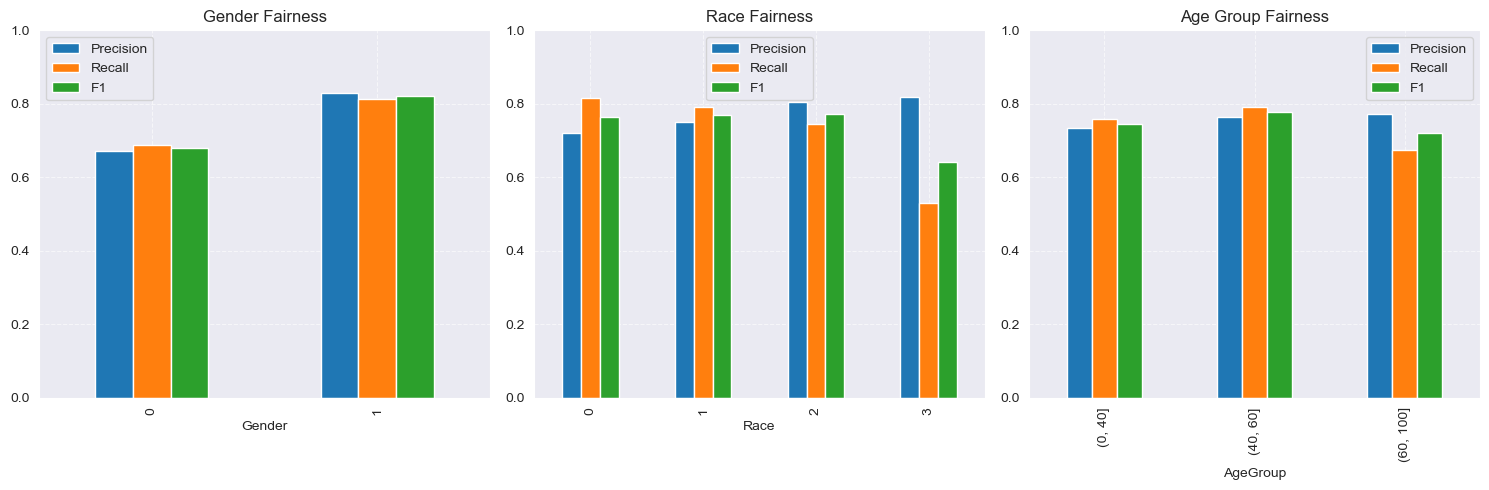

(        Precision    Recall        F1
 Gender                               
 0        0.670886  0.688312  0.679487
 1        0.830000  0.813725  0.821782,
       Precision    Recall        F1
 Race                               
 0      0.721311  0.814815  0.765217
 1      0.750000  0.792453  0.770642
 2      0.803922  0.745455  0.773585
 3      0.818182  0.529412  0.642857,
            Precision    Recall        F1
 AgeGroup                                
 (0, 40]     0.733333  0.758621  0.745763
 (40, 60]    0.763158  0.790909  0.776786
 (60, 100]   0.771429  0.675000  0.720000)

In [94]:
# ======================================================
# STEP 6: FAIRNESS ANALYSIS + VISUALIZATION
# ======================================================

import matplotlib.pyplot as plt

def fairness_analysis(data):
    X = data.drop(columns=["Diabetes"])
    y = data["Diabetes"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    pipe = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression(max_iter=1000))])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    df_eval = X_test.copy()
    df_eval["y_true"] = y_test.values
    df_eval["y_pred"] = y_pred

    def group_metrics(col):
        grouped = df_eval.groupby(col, observed=True)
        metrics = grouped.apply(
            lambda g: pd.Series({
                "Precision": precision_score(g["y_true"], g["y_pred"], zero_division=0),
                "Recall": recall_score(g["y_true"], g["y_pred"], zero_division=0),
                "F1": f1_score(g["y_true"], g["y_pred"], zero_division=0),
            }),
            include_groups=False
        )
        return metrics

    gender_metrics = group_metrics("Gender")
    race_metrics = group_metrics("Race")

    df_eval["AgeGroup"] = pd.cut(df_eval["Age"], bins=[0, 40, 60, 100])
    age_metrics = group_metrics("AgeGroup")

    print("\n=== Fairness Metrics ===")
    print("\nBy Gender:\n", gender_metrics)
    print("\nBy Race:\n", race_metrics)
    print("\nBy Age Group:\n", age_metrics)

    # ---- Visualization ----
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    gender_metrics.plot(kind="bar", ax=axes[0], title="Gender Fairness")
    race_metrics.plot(kind="bar", ax=axes[1], title="Race Fairness")
    age_metrics.plot(kind="bar", ax=axes[2], title="Age Group Fairness")

    for ax in axes:
        ax.set_ylim(0, 1)
        ax.grid(True, linestyle="--", alpha=0.6)

    plt.tight_layout()
    plt.show()

    return gender_metrics, race_metrics, age_metrics


# Example fairness evaluation
data = SyntheticDiabetesDataGenerator(1000)
fairness_analysis(data)
